In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
data_path = '/content/drive/MyDrive/dataset'
X, y = load_data(data_path)

In [ ]:
import pickle
import numpy as np

# Load data fitur dan label
with open('processed_features.pkl', 'rb') as f:
    X = pickle.load(f)

with open('processed_labels.pkl', 'rb') as f:
    y = pickle.load(f)

In [ ]:
# Function to extract features from audio
def extract_features_from_audio(y, sr, fixed_length=40):
    mfccs = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=fixed_length)
    mfccs = np.mean(mfccs.T, axis=0)

    chroma = librosa.feature.chroma_stft(y=y, sr=sr)
    chroma = np.mean(chroma.T, axis=0)

    mel = librosa.feature.melspectrogram(y=y, sr=sr)
    mel = np.mean(mel.T, axis=0)

    contrast = librosa.feature.spectral_contrast(y=y, sr=sr)
    contrast = np.mean(contrast.T, axis=0)

    tonnetz = librosa.feature.tonnetz(y=librosa.effects.harmonic(y), sr=sr)
    tonnetz = np.mean(tonnetz.T, axis=0)

    zcr = librosa.feature.zero_crossing_rate(y)
    zcr = np.mean(zcr.T, axis=0)

    rmse = librosa.feature.rms(y=y)
    rmse = np.mean(rmse.T, axis=0)

    # Function to pad or trim features to the fixed length
    def pad_or_trim(feature, length):
        if len(feature) < length:
            return np.pad(feature, (0, length - len(feature)), mode='constant')
        else:
            return feature[:length]

    # Apply padding or trimming to each feature to ensure the fixed length
    mfccs = pad_or_trim(mfccs, fixed_length)
    chroma = pad_or_trim(chroma, fixed_length)
    mel = pad_or_trim(mel, fixed_length)
    contrast = pad_or_trim(contrast, fixed_length)
    tonnetz = pad_or_trim(tonnetz, fixed_length)
    zcr = pad_or_trim(zcr, fixed_length)
    rmse = pad_or_trim(rmse, fixed_length)

    # Concatenate all features into a single feature vector
    return np.concatenate([mfccs, chroma, mel, contrast, tonnetz, zcr, rmse])

In [ ]:
# Function to load data and perform data augmentation
def load_data(data_path, fixed_length=40):
    features = []
    labels = []
    for label, class_dir in enumerate(['human', 'ai']):
        class_path = os.path.join(data_path, class_dir)
        for file in os.listdir(class_path):
            file_path = os.path.join(class_path, file)
            if file_path.endswith('.wav'):
                y, sr = librosa.load(file_path, sr=None)

                # Extracting the original features
                feature = extract_features_from_audio(y, sr, fixed_length=fixed_length)
                features.append(feature)
                labels.append(label)

                # Data augmentation: adding slight noise
                noise = np.random.normal(0, 0.005, y.shape)
                y_noise = y + noise
                features.append(extract_features_from_audio(y_noise, sr, fixed_length=fixed_length))
                labels.append(label)

                # Data augmentation: shifting time
                shift_range = int(0.1 * len(y))
                y_shift = np.roll(y, shift_range)
                features.append(extract_features_from_audio(y_shift, sr, fixed_length=fixed_length))
                labels.append(label)

                # Data augmentation: pitch shifting slightly
                y_pitch_shift = librosa.effects.pitch_shift(y, sr=sr, n_steps=2)
                features.append(extract_features_from_audio(y_pitch_shift, sr, fixed_length=fixed_length))
                labels.append(label)

                # Data augmentation: changing speed slightly
                y_stretch = librosa.effects.time_stretch(y, rate=1.1)
                features.append(extract_features_from_audio(y_stretch, sr, fixed_length=fixed_length))
                labels.append(label)

    return np.array(features), np.array(labels)

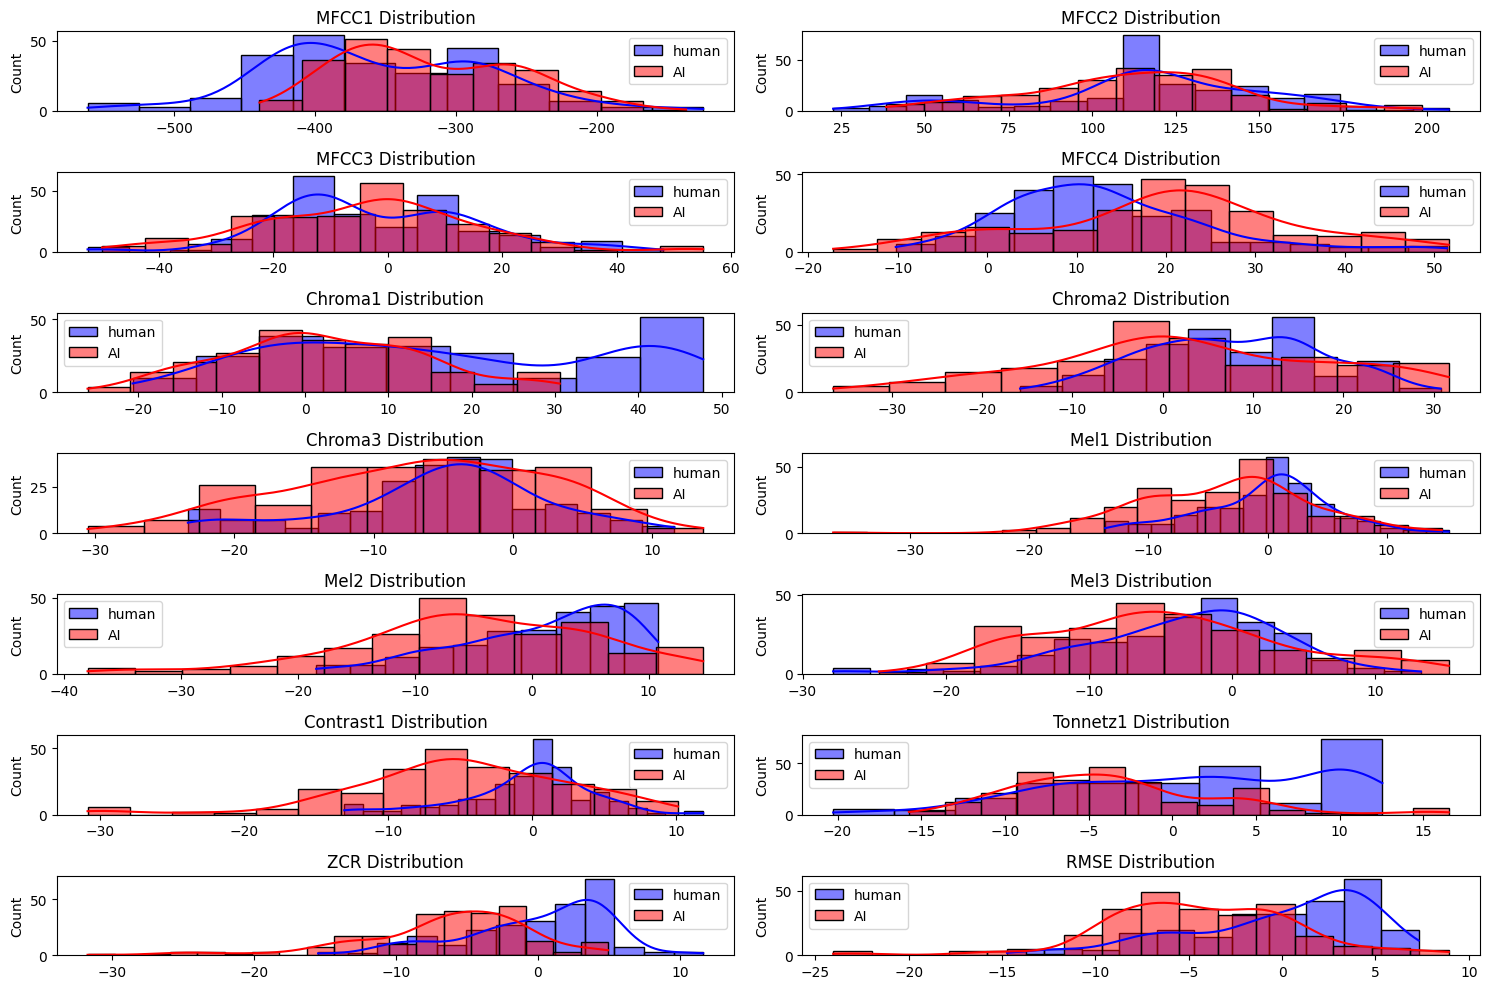

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

def plot_feature_distribution(X, y, feature_names):
    fig, axes = plt.subplots(nrows=len(feature_names)//2, ncols=2, figsize=(15, 10))
    axes = axes.flatten()

    for i, ax in enumerate(axes):
        sns.histplot(X[y == 0][:, i], color='blue', kde=True, label='human', ax=ax)
        sns.histplot(X[y == 1][:, i], color='red', kde=True, label='AI', ax=ax)
        ax.set_title(f'{feature_names[i]} Distribution')
        ax.legend()

    plt.tight_layout()
    plt.show()

# Feature names (this should match the number of features used)
feature_names = ['MFCC1', 'MFCC2', 'MFCC3', 'MFCC4', 'Chroma1', 'Chroma2', 'Chroma3', 'Mel1', 'Mel2', 'Mel3', 'Contrast1', 'Tonnetz1', 'ZCR', 'RMSE']

# Call the function to plot feature distribution
plot_feature_distribution(X, y, feature_names)

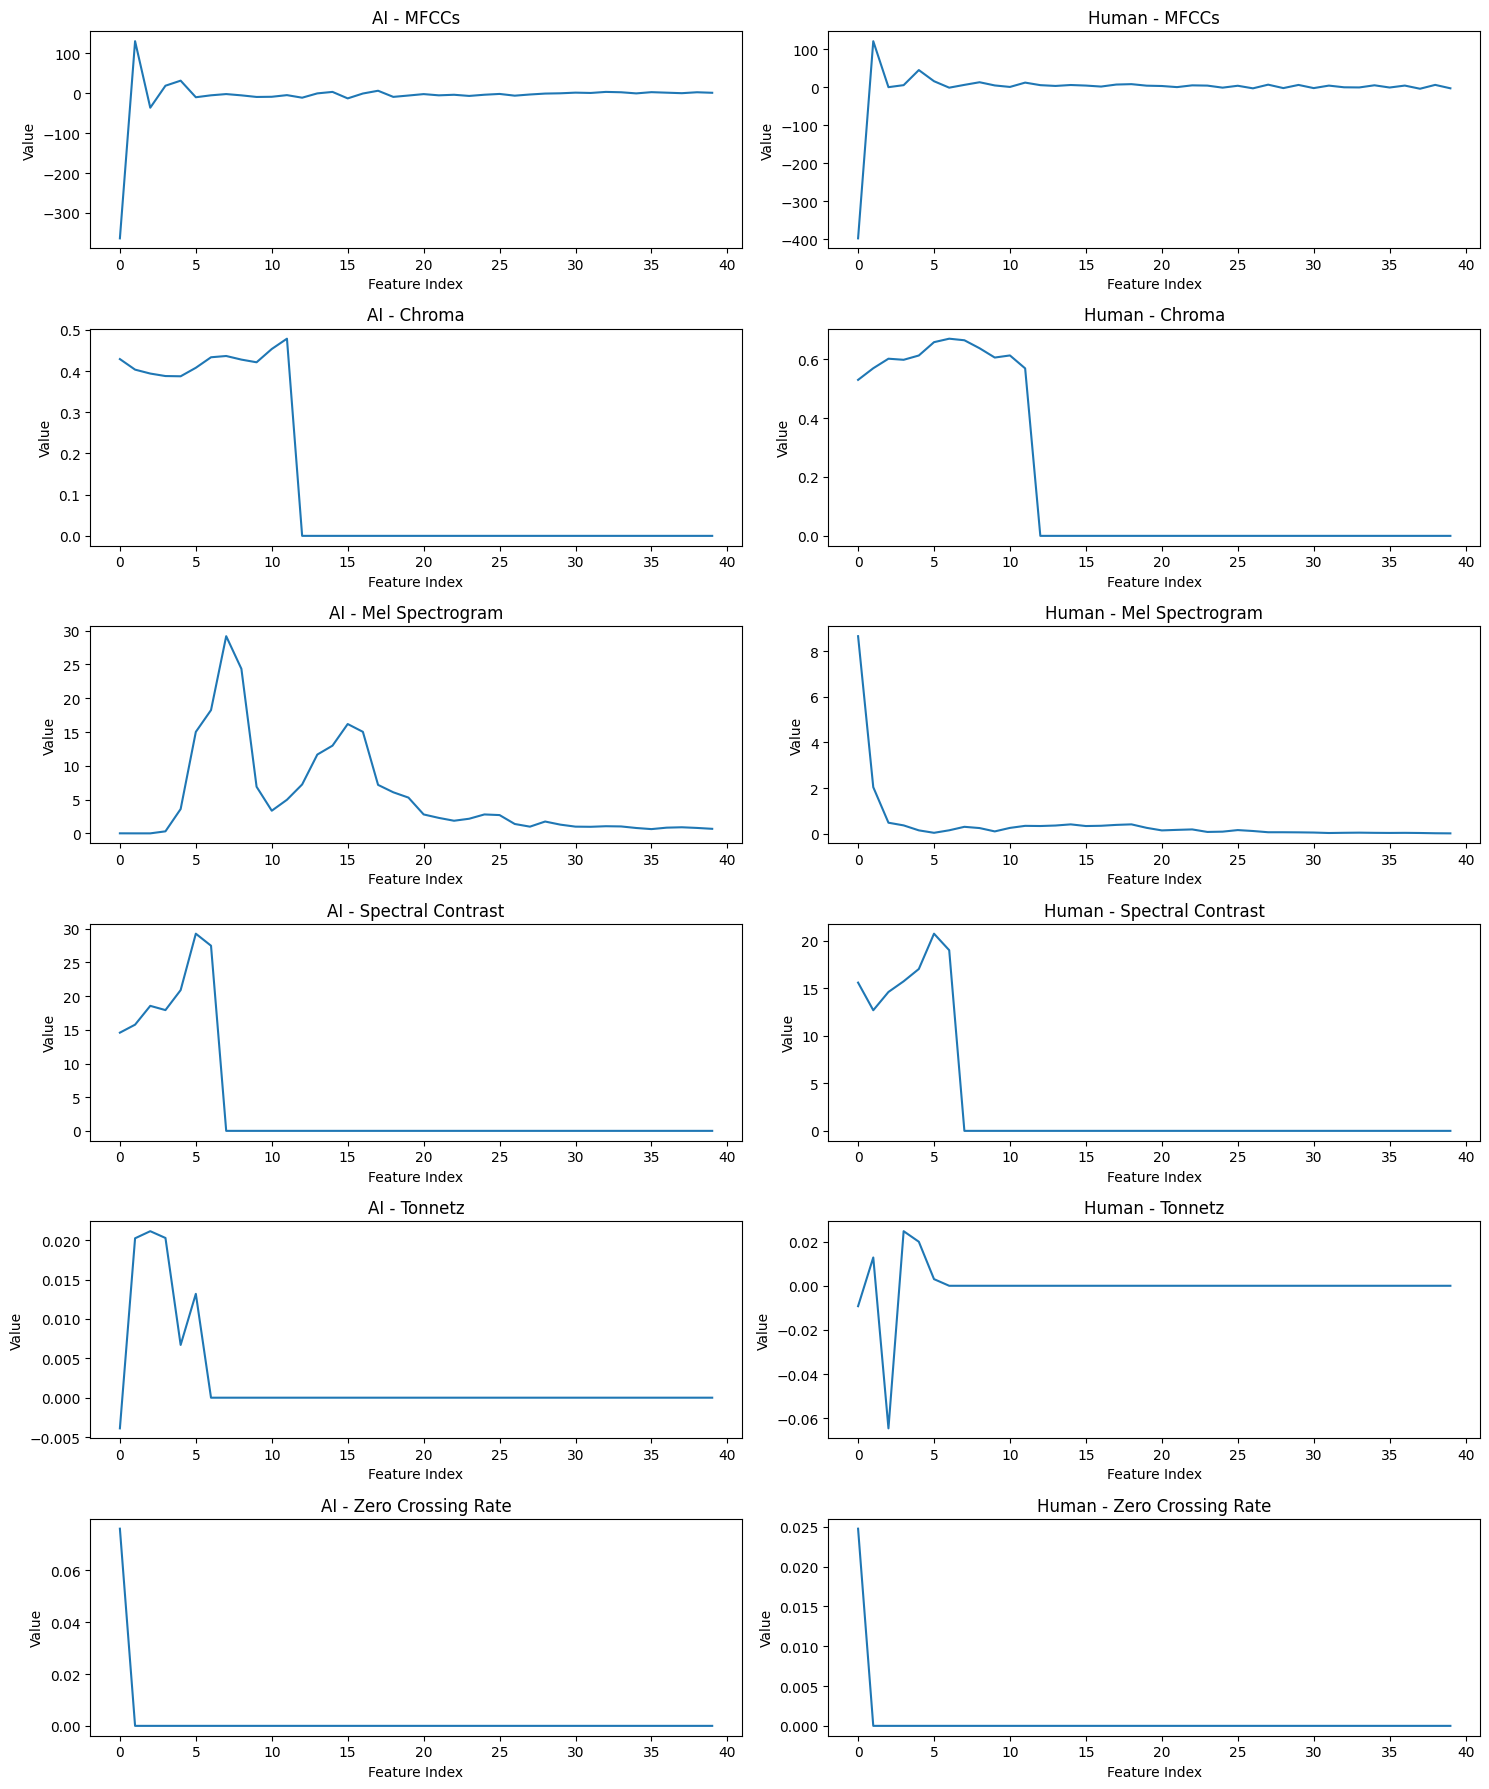

In [ ]:
import os
import numpy as np
import librosa
import matplotlib.pyplot as plt

# Function to plot audio features
def plot_features(features_human, features_ai, feature_names, fixed_length):
    num_features = len(feature_names)
    plt.figure(figsize=(15, num_features * 3))

    for i, feature_name in enumerate(feature_names):
        # Plot for AI features
        plt.subplot(num_features, 2, i * 2 + 1)
        plt.plot(features_ai[i * fixed_length:(i + 1) * fixed_length])
        plt.title(f'AI - {feature_name}')
        plt.xlabel('Feature Index')
        plt.ylabel('Value')

        # Plot for Human features
        plt.subplot(num_features, 2, i * 2 + 2)
        plt.plot(features_human[i * fixed_length:(i + 1) * fixed_length])
        plt.title(f'Human - {feature_name}')
        plt.xlabel('Feature Index')
        plt.ylabel('Value')

    plt.tight_layout()
    plt.show()

# Extract features and labels from the data
def extract_and_visualize(data_path, human_file, ai_file, fixed_length=40):
    feature_names = ['MFCCs', 'Chroma', 'Mel Spectrogram', 'Spectral Contrast', 'Tonnetz', 'Zero Crossing Rate']

    # Load the human and AI audio files
    y_human, sr_human = librosa.load(os.path.join(data_path, 'human', human_file), sr=None)
    y_ai, sr_ai = librosa.load(os.path.join(data_path, 'ai', ai_file), sr=None)

    # Extract features from both audio files
    features_human = extract_features_from_audio(y_human, sr_human, fixed_length=fixed_length)
    features_ai = extract_features_from_audio(y_ai, sr_ai, fixed_length=fixed_length)

    # Plot the features
    plot_features(features_human, features_ai, feature_names, fixed_length)

# Example usage:
data_path = '/content/test'
human_file = '/content/test/Test(English Real Audio).wav'
ai_file = '/content/test/Test(English Clone).wav'

extract_and_visualize(data_path, human_file, ai_file, fixed_length=40)

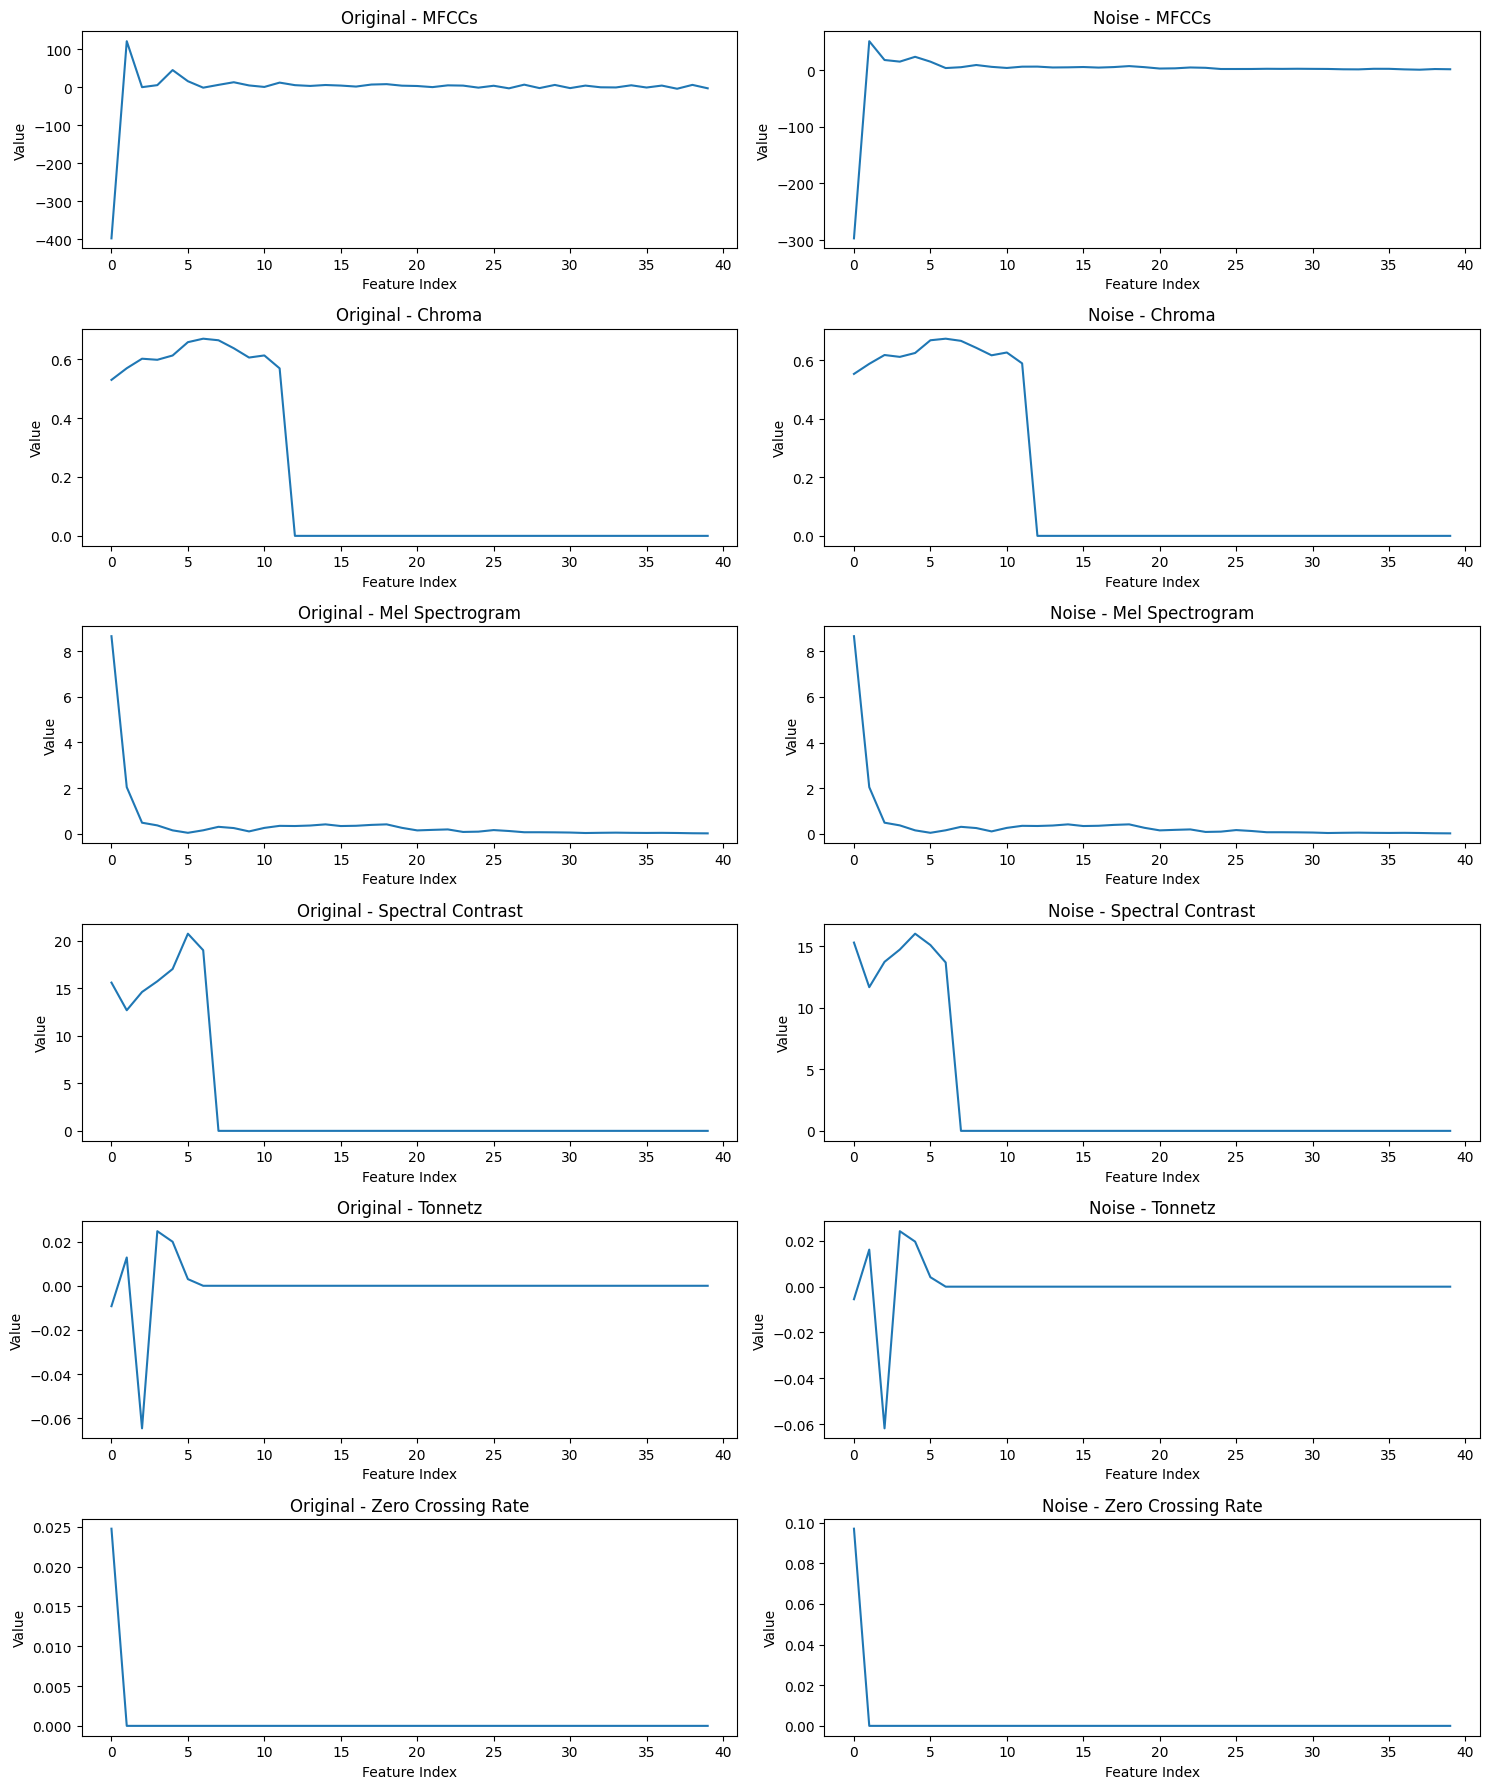

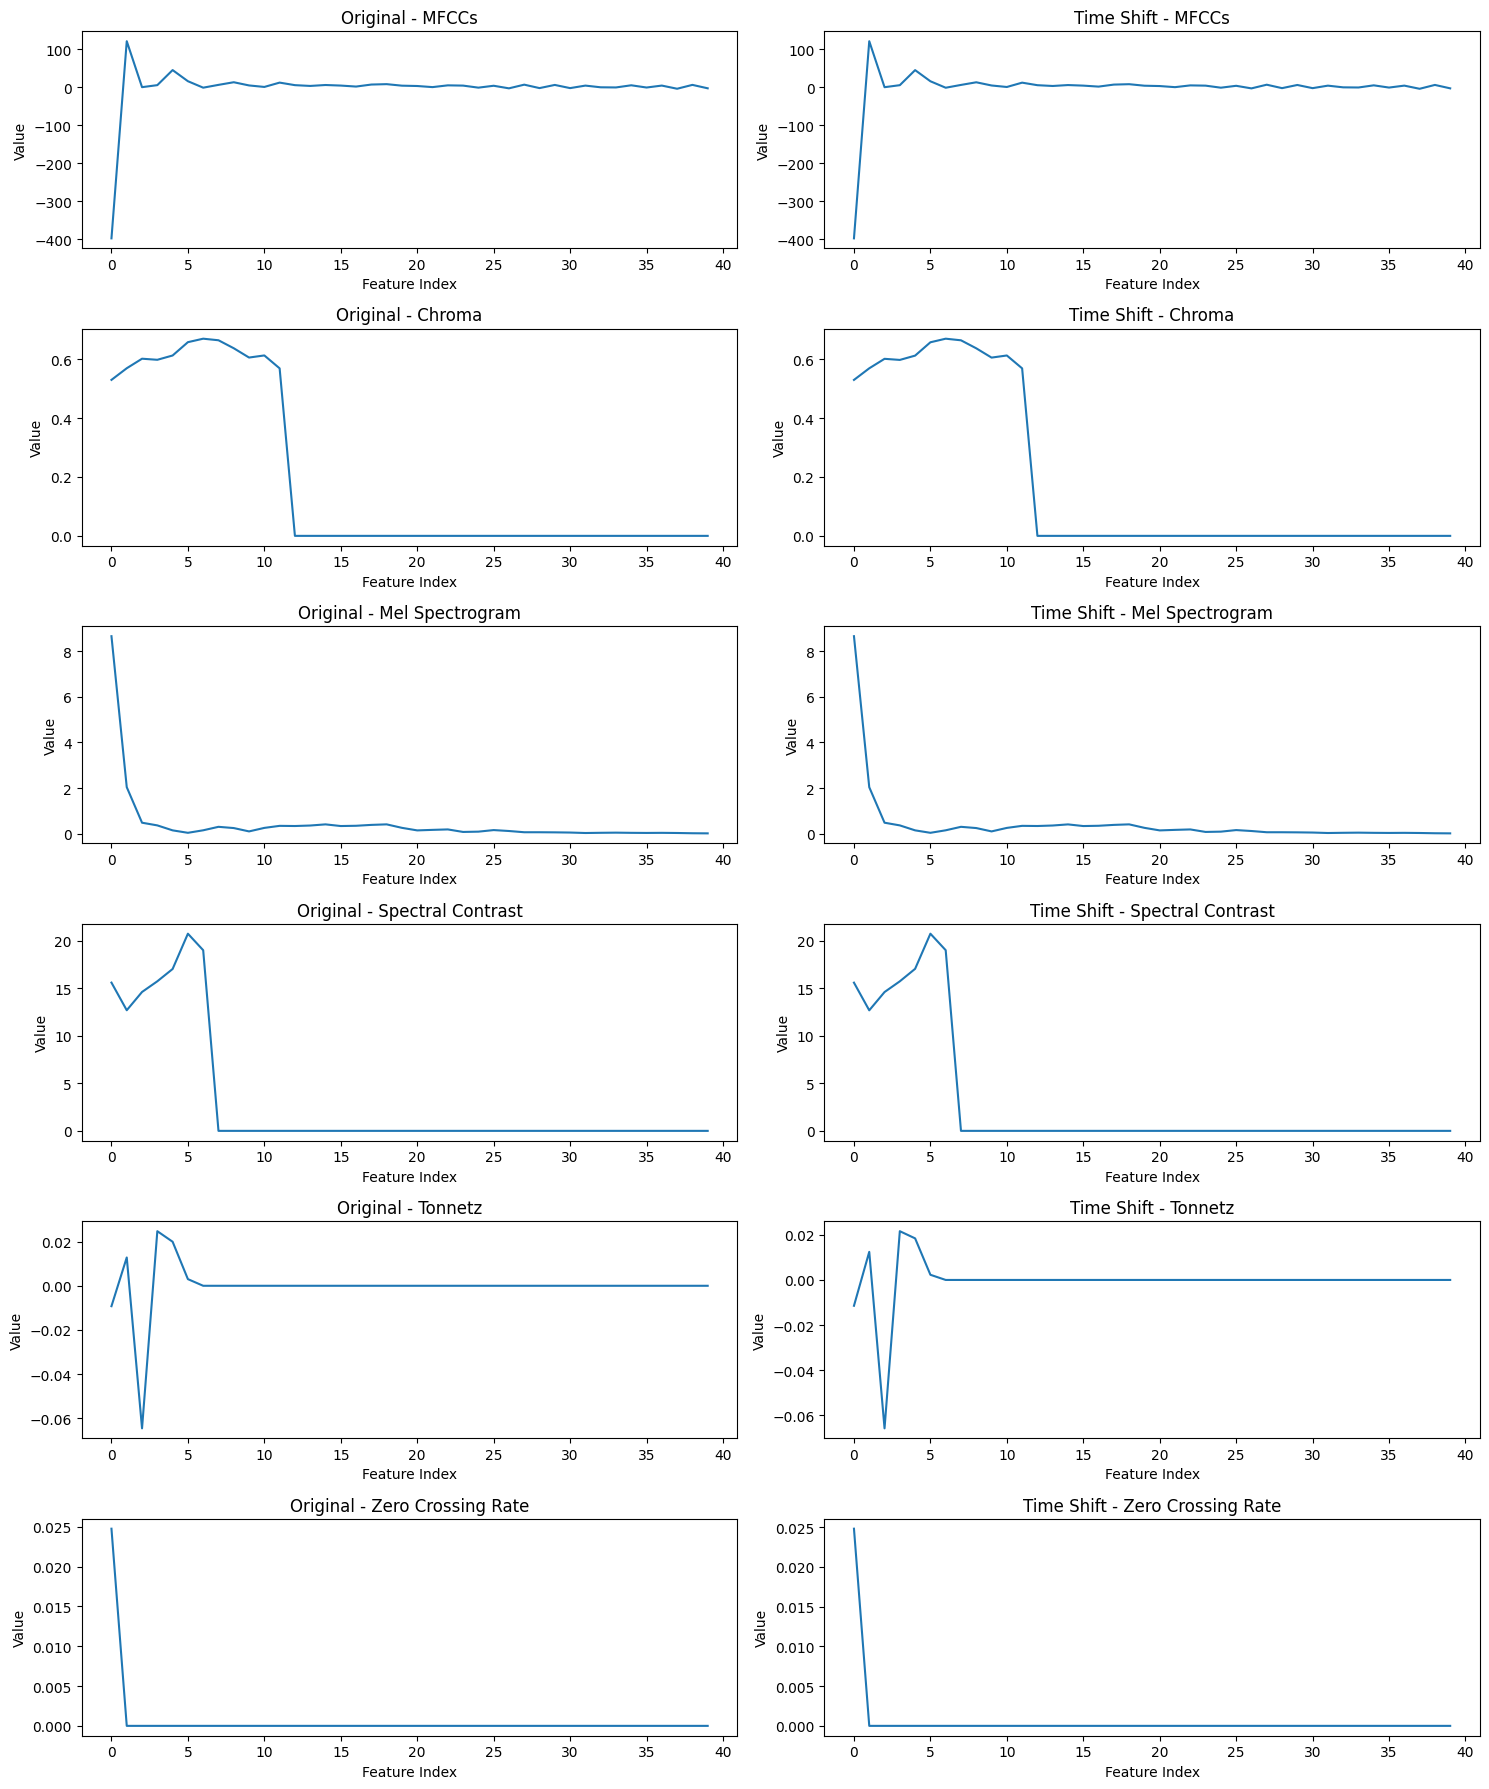

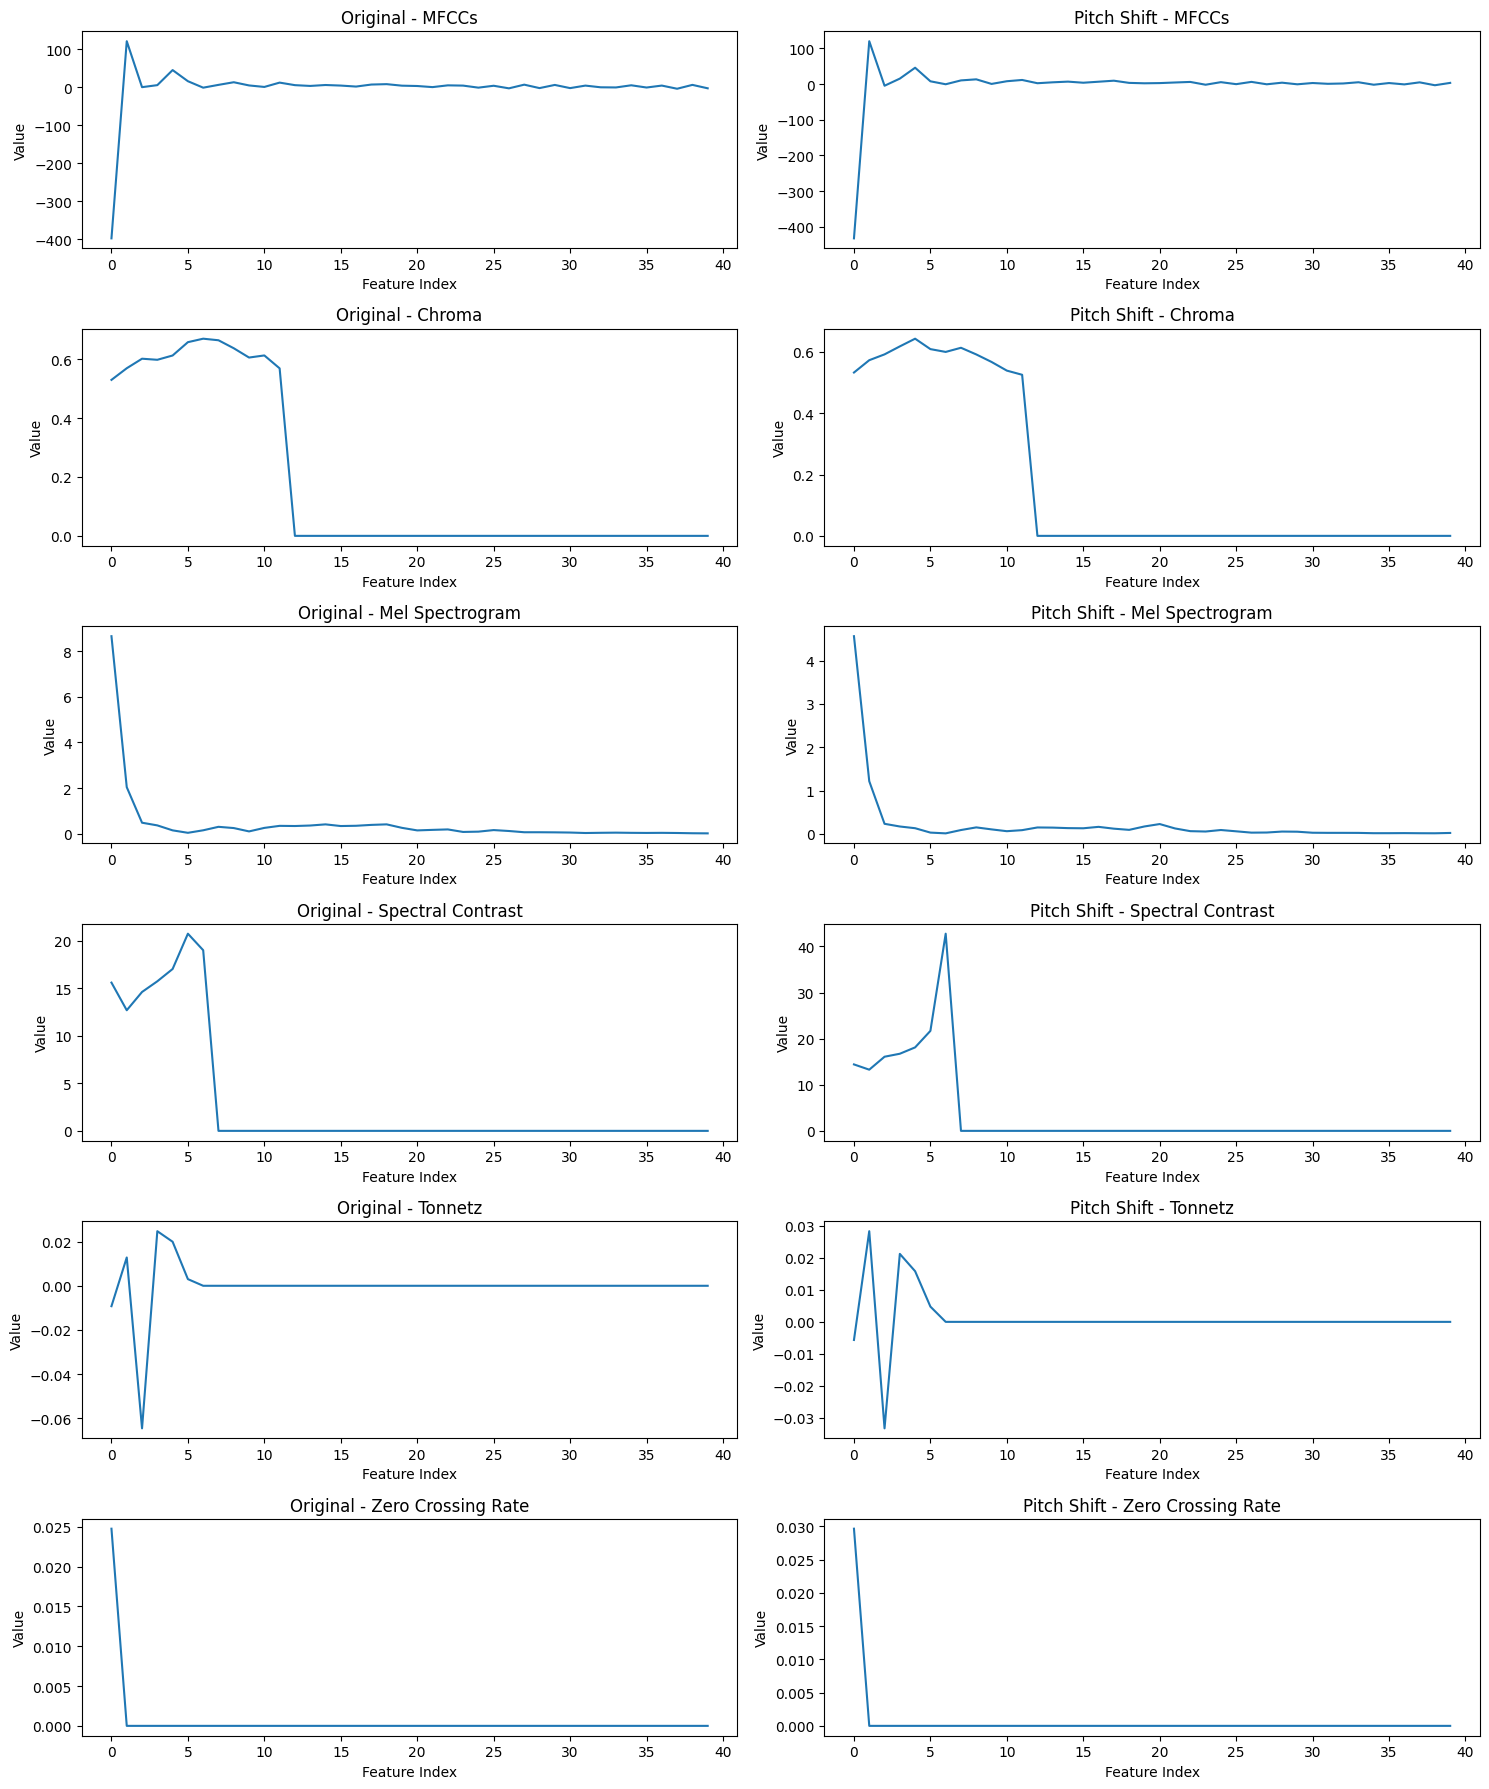

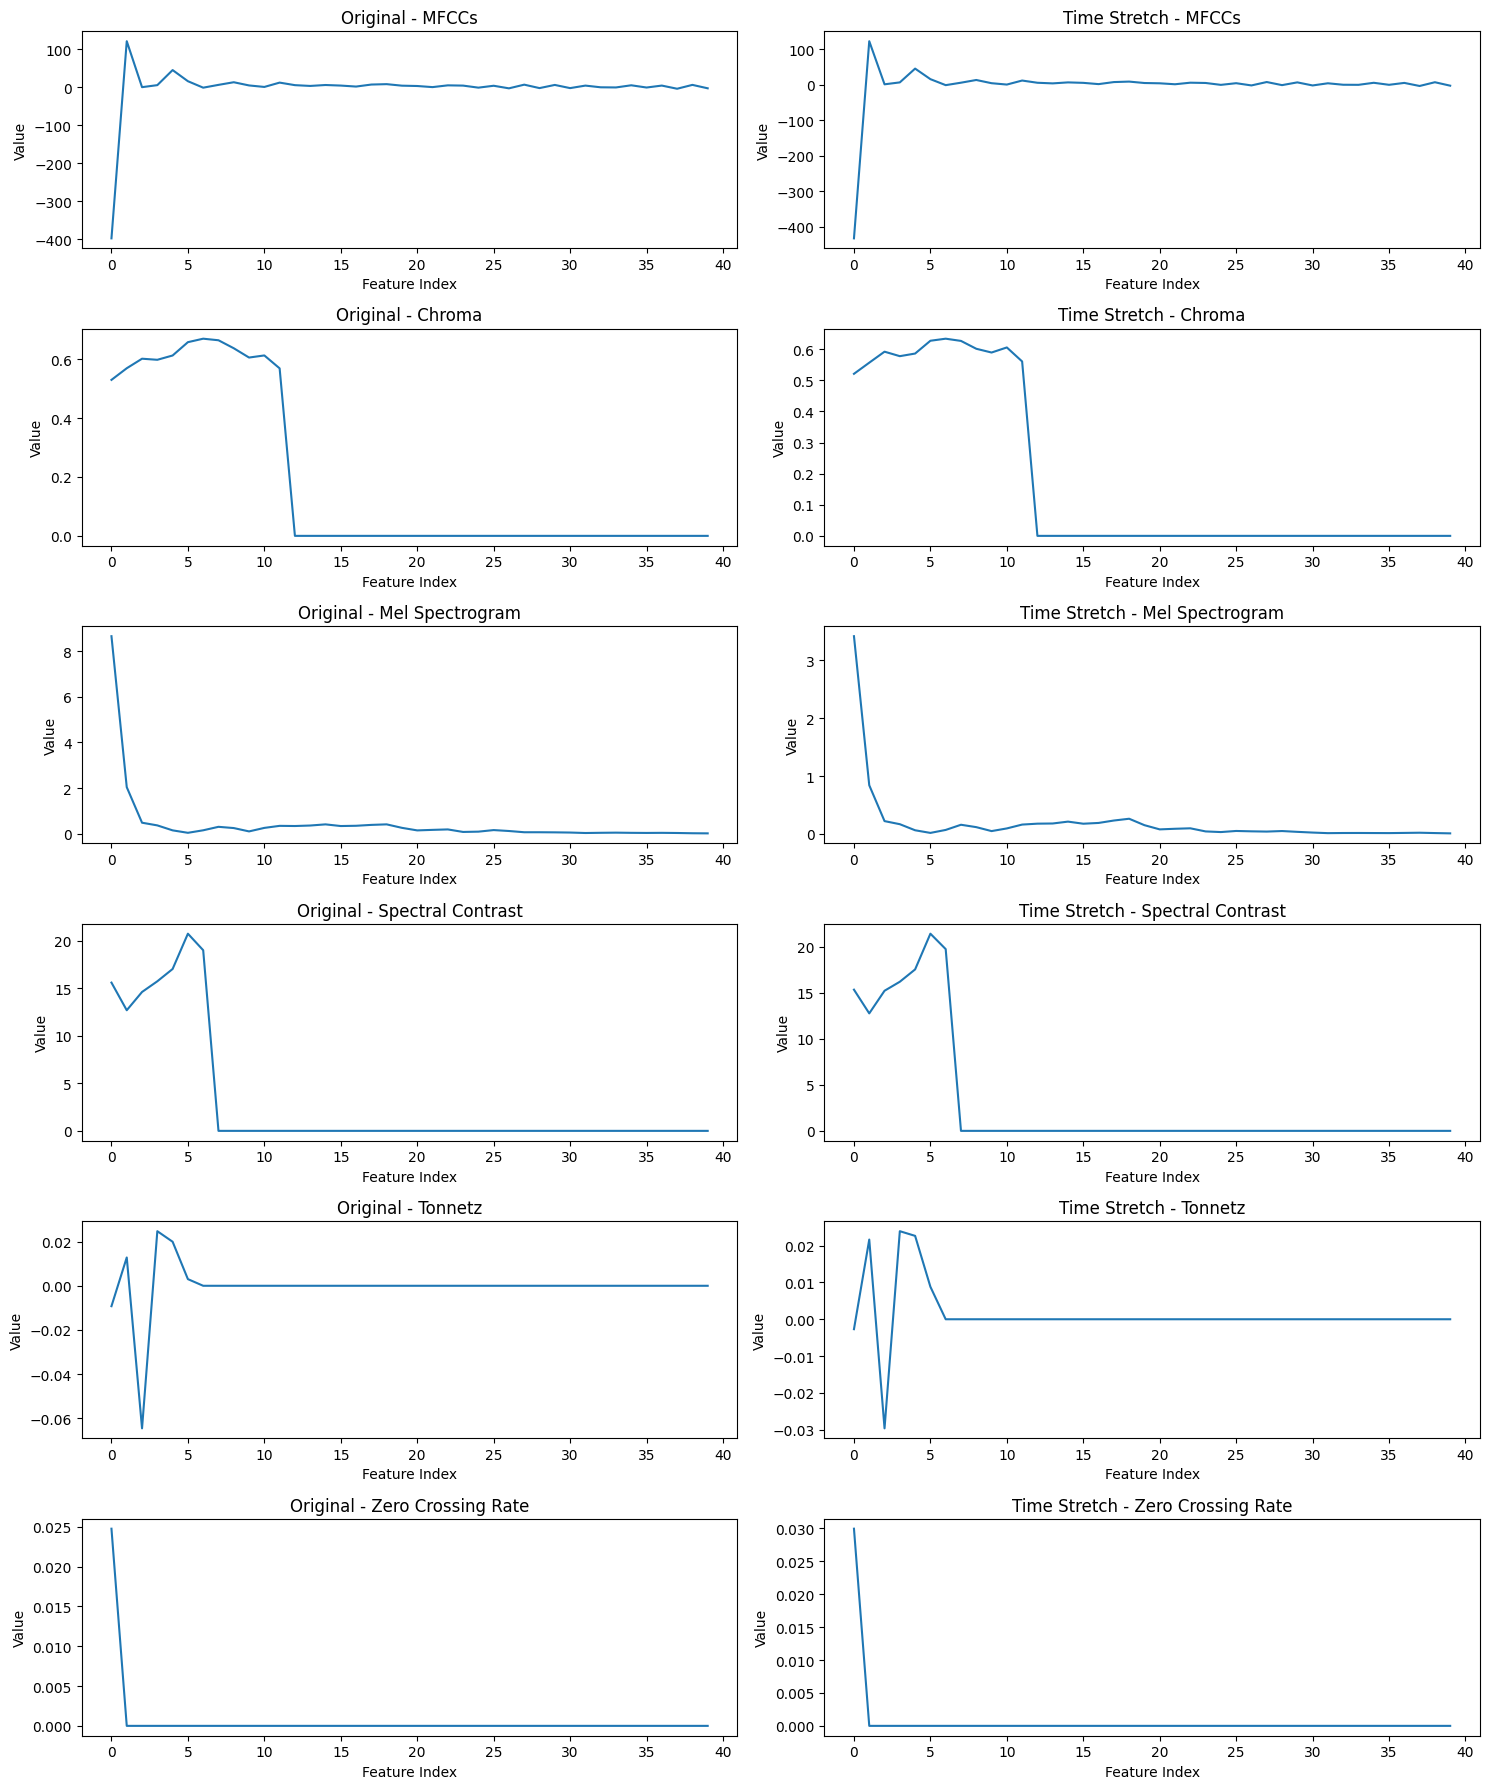

In [ ]:
import os
import numpy as np
import librosa
import matplotlib.pyplot as plt

# Function to plot audio features before and after augmentation
def plot_features_before_after(features_before, features_after, feature_names, fixed_length, augment_type):
    num_features = len(feature_names)
    plt.figure(figsize=(15, num_features * 3))

    for i, feature_name in enumerate(feature_names):
        # Plot for features before augmentation
        plt.subplot(num_features, 2, i * 2 + 1)
        plt.plot(features_before[i * fixed_length:(i + 1) * fixed_length])
        plt.title(f'Original - {feature_name}')
        plt.xlabel('Feature Index')
        plt.ylabel('Value')

        # Plot for features after augmentation
        plt.subplot(num_features, 2, i * 2 + 2)
        plt.plot(features_after[i * fixed_length:(i + 1) * fixed_length])
        plt.title(f'{augment_type} - {feature_name}')
        plt.xlabel('Feature Index')
        plt.ylabel('Value')

    plt.tight_layout()
    plt.show()

# Extract features and visualize before and after augmentation
def extract_and_visualize_before_after(data_path, human_file, fixed_length=40):
    feature_names = ['MFCCs', 'Chroma', 'Mel Spectrogram', 'Spectral Contrast', 'Tonnetz', 'Zero Crossing Rate']

    # Load the human audio file
    y_human, sr_human = librosa.load(os.path.join(data_path, 'human', human_file), sr=None)

    # Extract features from the original human audio
    features_before = extract_features_from_audio(y_human, sr_human, fixed_length=fixed_length)

    # Augmentation examples

    # 1. Add slight noise
    noise = np.random.normal(0, 0.005, y_human.shape)
    y_noise = y_human + noise
    features_after_noise = extract_features_from_audio(y_noise, sr_human, fixed_length=fixed_length)
    plot_features_before_after(features_before, features_after_noise, feature_names, fixed_length, 'Noise')

    # 2. Time shifting
    shift_range = int(0.1 * len(y_human))
    y_shift = np.roll(y_human, shift_range)
    features_after_shift = extract_features_from_audio(y_shift, sr_human, fixed_length=fixed_length)
    plot_features_before_after(features_before, features_after_shift, feature_names, fixed_length, 'Time Shift')

    # 3. Pitch shifting
    y_pitch_shift = librosa.effects.pitch_shift(y_human, sr=sr_human, n_steps=2)
    features_after_pitch_shift = extract_features_from_audio(y_pitch_shift, sr_human, fixed_length=fixed_length)
    plot_features_before_after(features_before, features_after_pitch_shift, feature_names, fixed_length, 'Pitch Shift')

    # 4. Time stretching
    y_stretch = librosa.effects.time_stretch(y_human, rate=1.1)
    features_after_stretch = extract_features_from_audio(y_stretch, sr_human, fixed_length=fixed_length)
    plot_features_before_after(features_before, features_after_stretch, feature_names, fixed_length, 'Time Stretch')

# Example usage:
data_path = '/content/test'
human_file = '/content/test/Test(English Real Audio).wav'

extract_and_visualize_before_after(data_path, human_file, fixed_length=40)


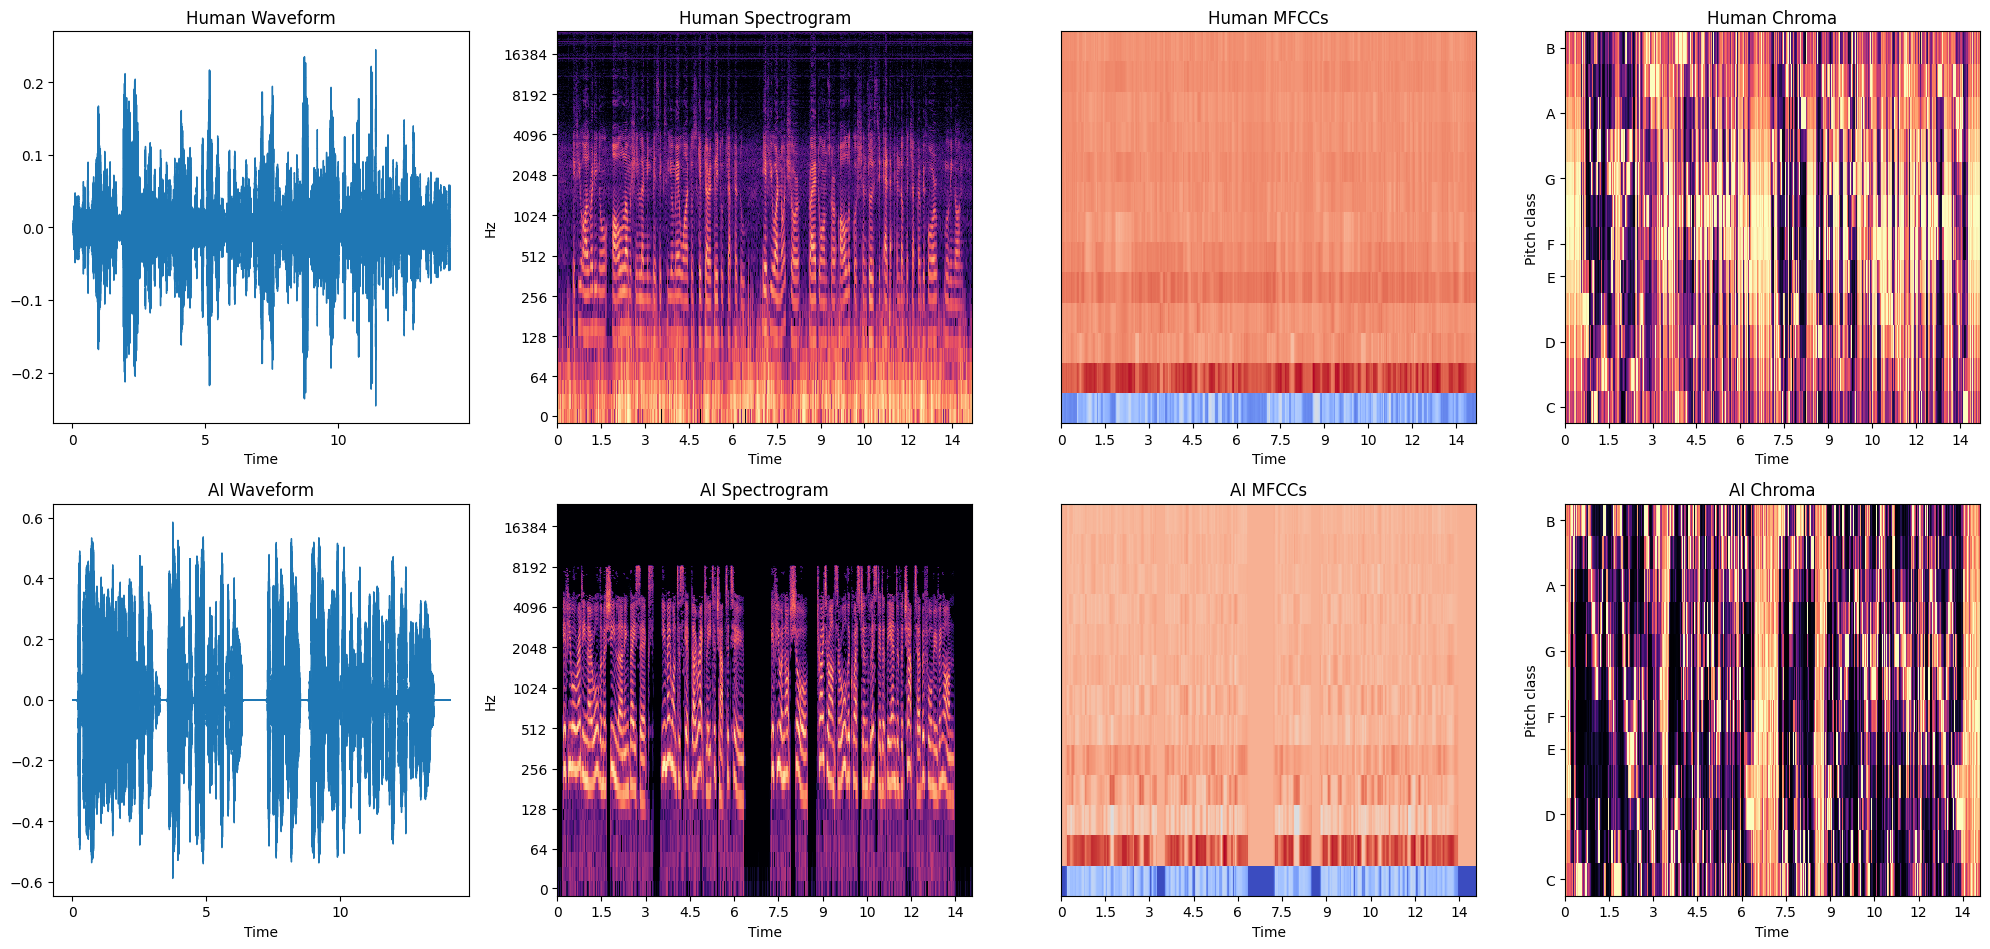

In [ ]:
import os
import numpy as np
import matplotlib.pyplot as plt
import librosa
import librosa.display

# Function to plot waveforms, spectrograms, MFCCs, chroma, etc.
def plot_librosa_visualizations(y_human, sr_human, y_ai, sr_ai):
    fig, axs = plt.subplots(2, 4, figsize=(20, 10))
    #fig.suptitle('Librosa Visualizations: Human (Left) vs AI (Right)', fontsize=16)

    # Plot waveform
    librosa.display.waveshow(y_human, sr=sr_human, ax=axs[0, 0])
    axs[0, 0].set_title('Human Waveform')
    librosa.display.waveshow(y_ai, sr=sr_ai, ax=axs[1, 0])
    axs[1, 0].set_title('AI Waveform')

    # Plot spectrogram
    D_human = librosa.amplitude_to_db(np.abs(librosa.stft(y_human)), ref=np.max)
    D_ai = librosa.amplitude_to_db(np.abs(librosa.stft(y_ai)), ref=np.max)
    librosa.display.specshow(D_human, sr=sr_human, x_axis='time', y_axis='log', ax=axs[0, 1])
    axs[0, 1].set_title('Human Spectrogram')
    librosa.display.specshow(D_ai, sr=sr_ai, x_axis='time', y_axis='log', ax=axs[1, 1])
    axs[1, 1].set_title('AI Spectrogram')

    # Plot MFCCs
    mfccs_human = librosa.feature.mfcc(y=y_human, sr=sr_human, n_mfcc=13)
    mfccs_ai = librosa.feature.mfcc(y=y_ai, sr=sr_ai, n_mfcc=13)
    librosa.display.specshow(mfccs_human, sr=sr_human, x_axis='time', ax=axs[0, 2])
    axs[0, 2].set_title('Human MFCCs')
    librosa.display.specshow(mfccs_ai, sr=sr_ai, x_axis='time', ax=axs[1, 2])
    axs[1, 2].set_title('AI MFCCs')

    # Plot chroma feature
    chroma_human = librosa.feature.chroma_stft(y=y_human, sr=sr_human)
    chroma_ai = librosa.feature.chroma_stft(y=y_ai, sr=sr_ai)
    librosa.display.specshow(chroma_human, sr=sr_human, x_axis='time', y_axis='chroma', ax=axs[0, 3])
    axs[0, 3].set_title('Human Chroma')
    librosa.display.specshow(chroma_ai, sr=sr_ai, x_axis='time', y_axis='chroma', ax=axs[1, 3])
    axs[1, 3].set_title('AI Chroma')

    plt.tight_layout(rect=[0, 0, 1, 0.96])
    plt.show()

# Load a single audio file from each class (human and AI)
human_path = '/content/test/Test(English Real Audio).wav'
ai_path = '/content/test/Test(English Clone).wav'

# Load the human and AI audio files
y_human, sr_human = librosa.load(human_path, sr=None)
y_ai, sr_ai = librosa.load(ai_path, sr=None)

# Plot the visualizations
plot_librosa_visualizations(y_human, sr_human, y_ai, sr_ai)

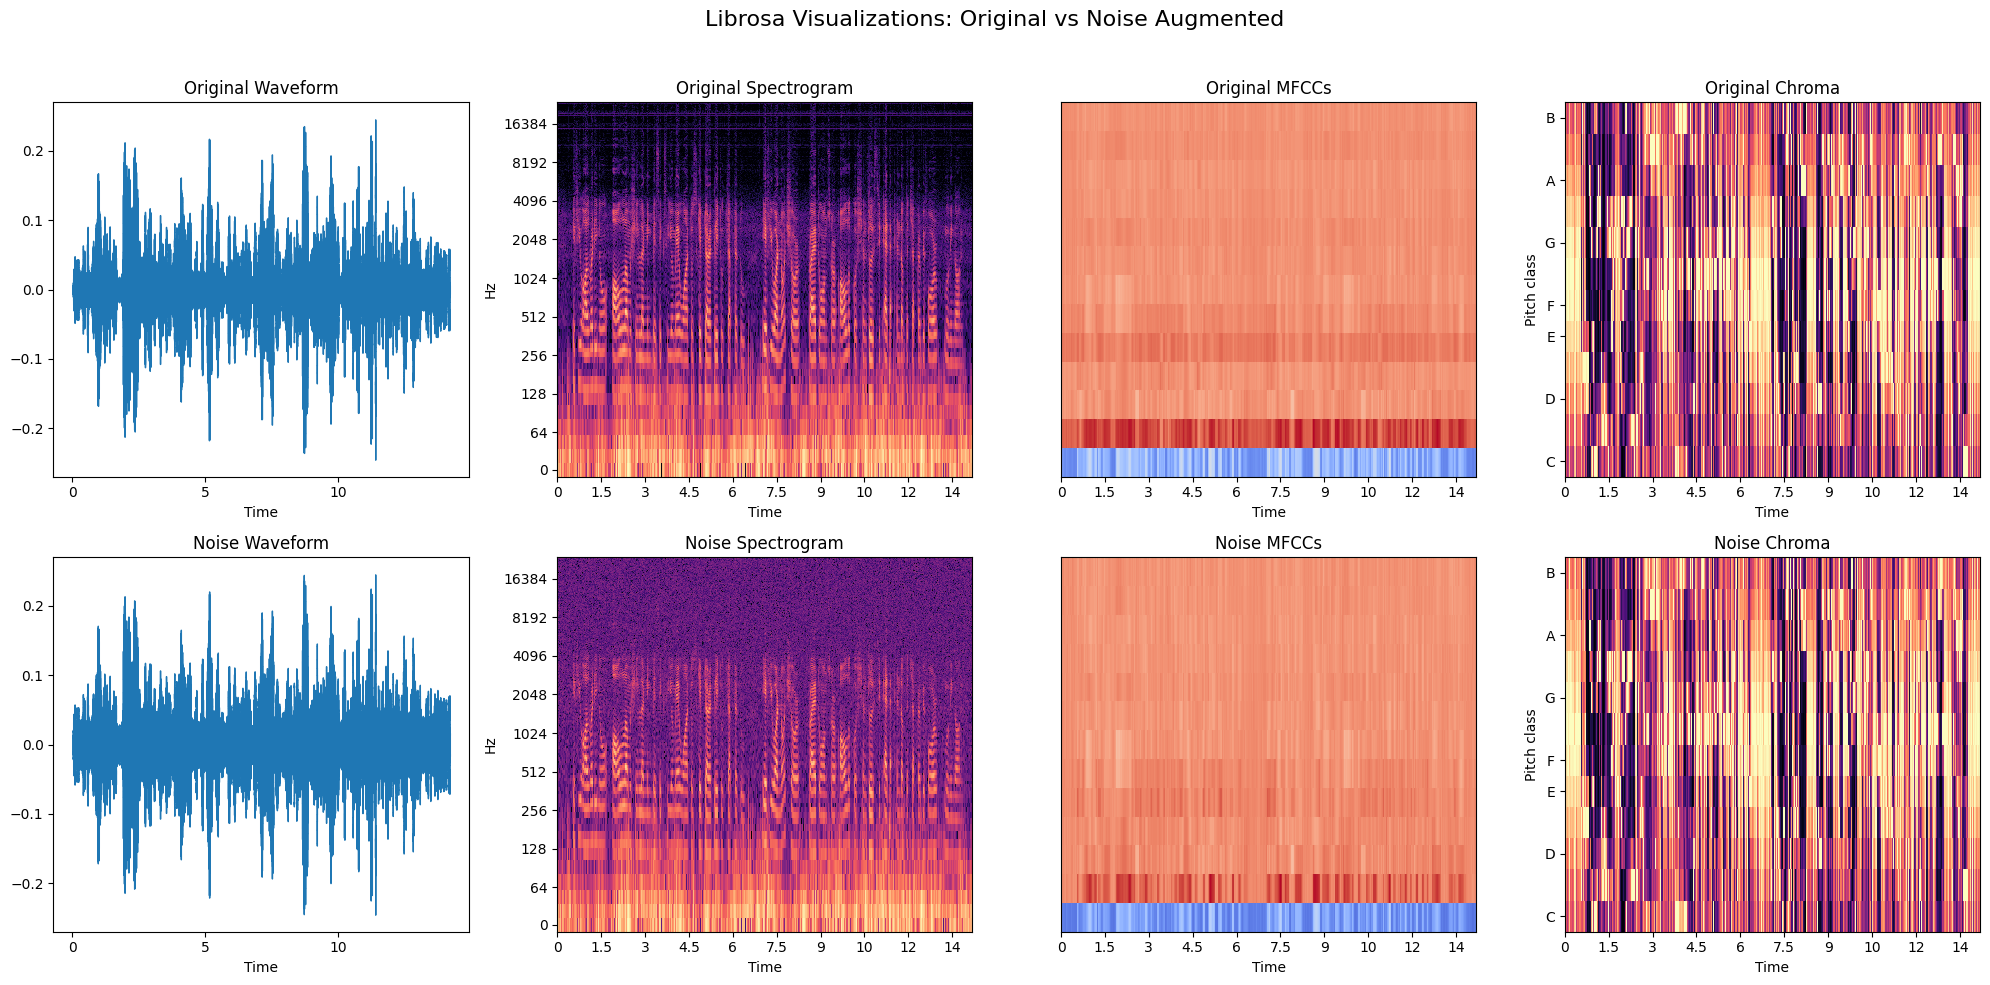

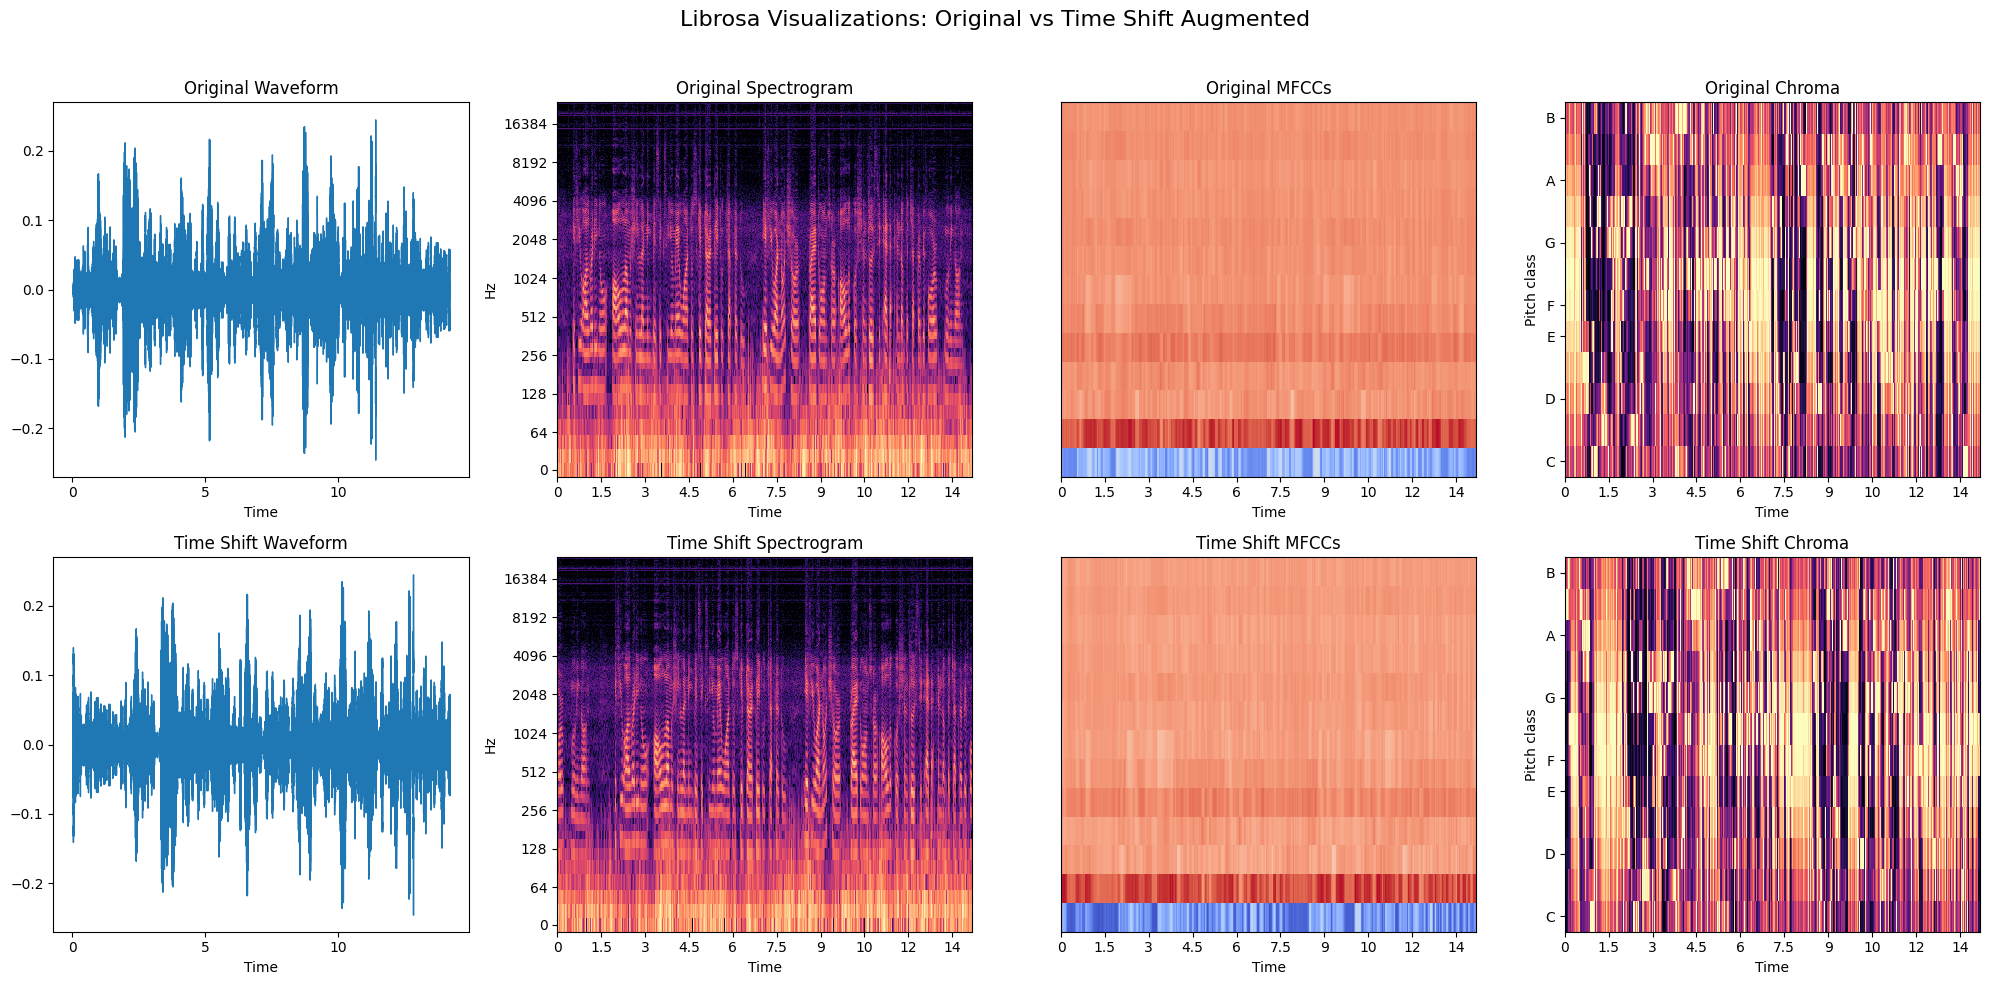

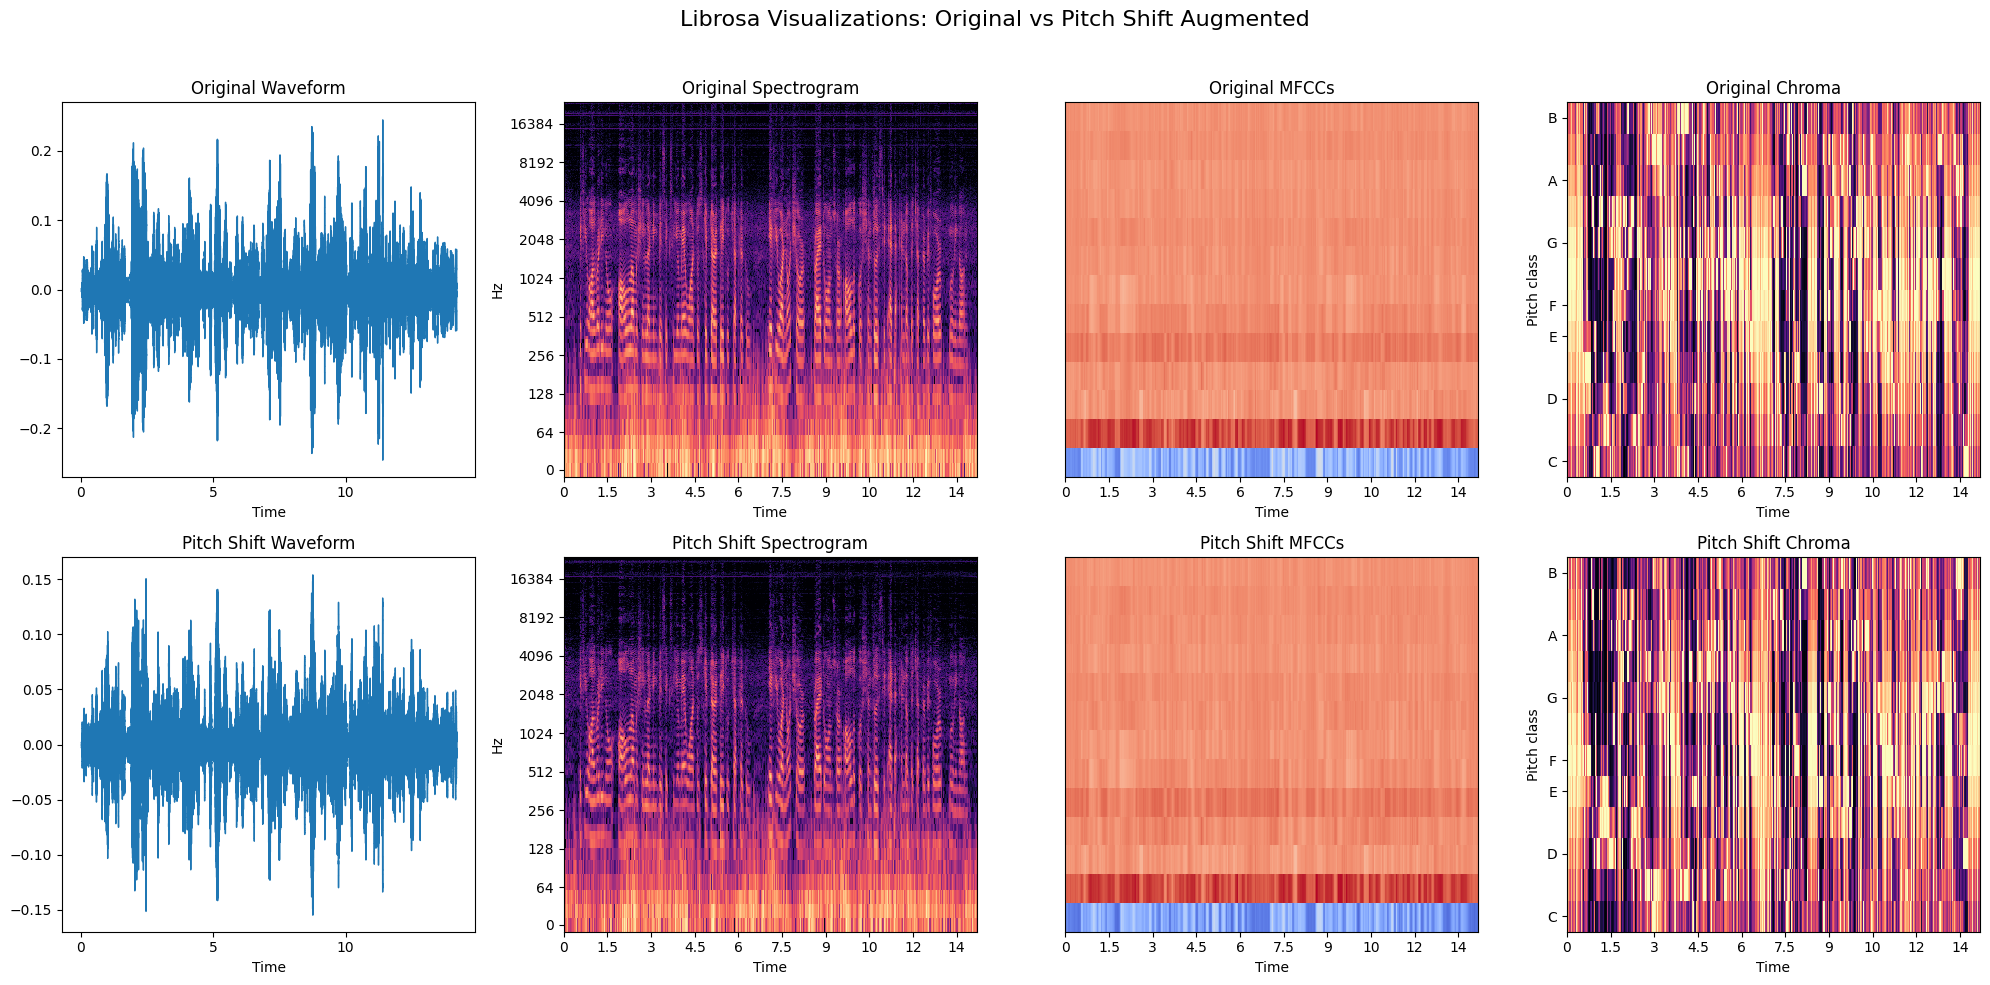

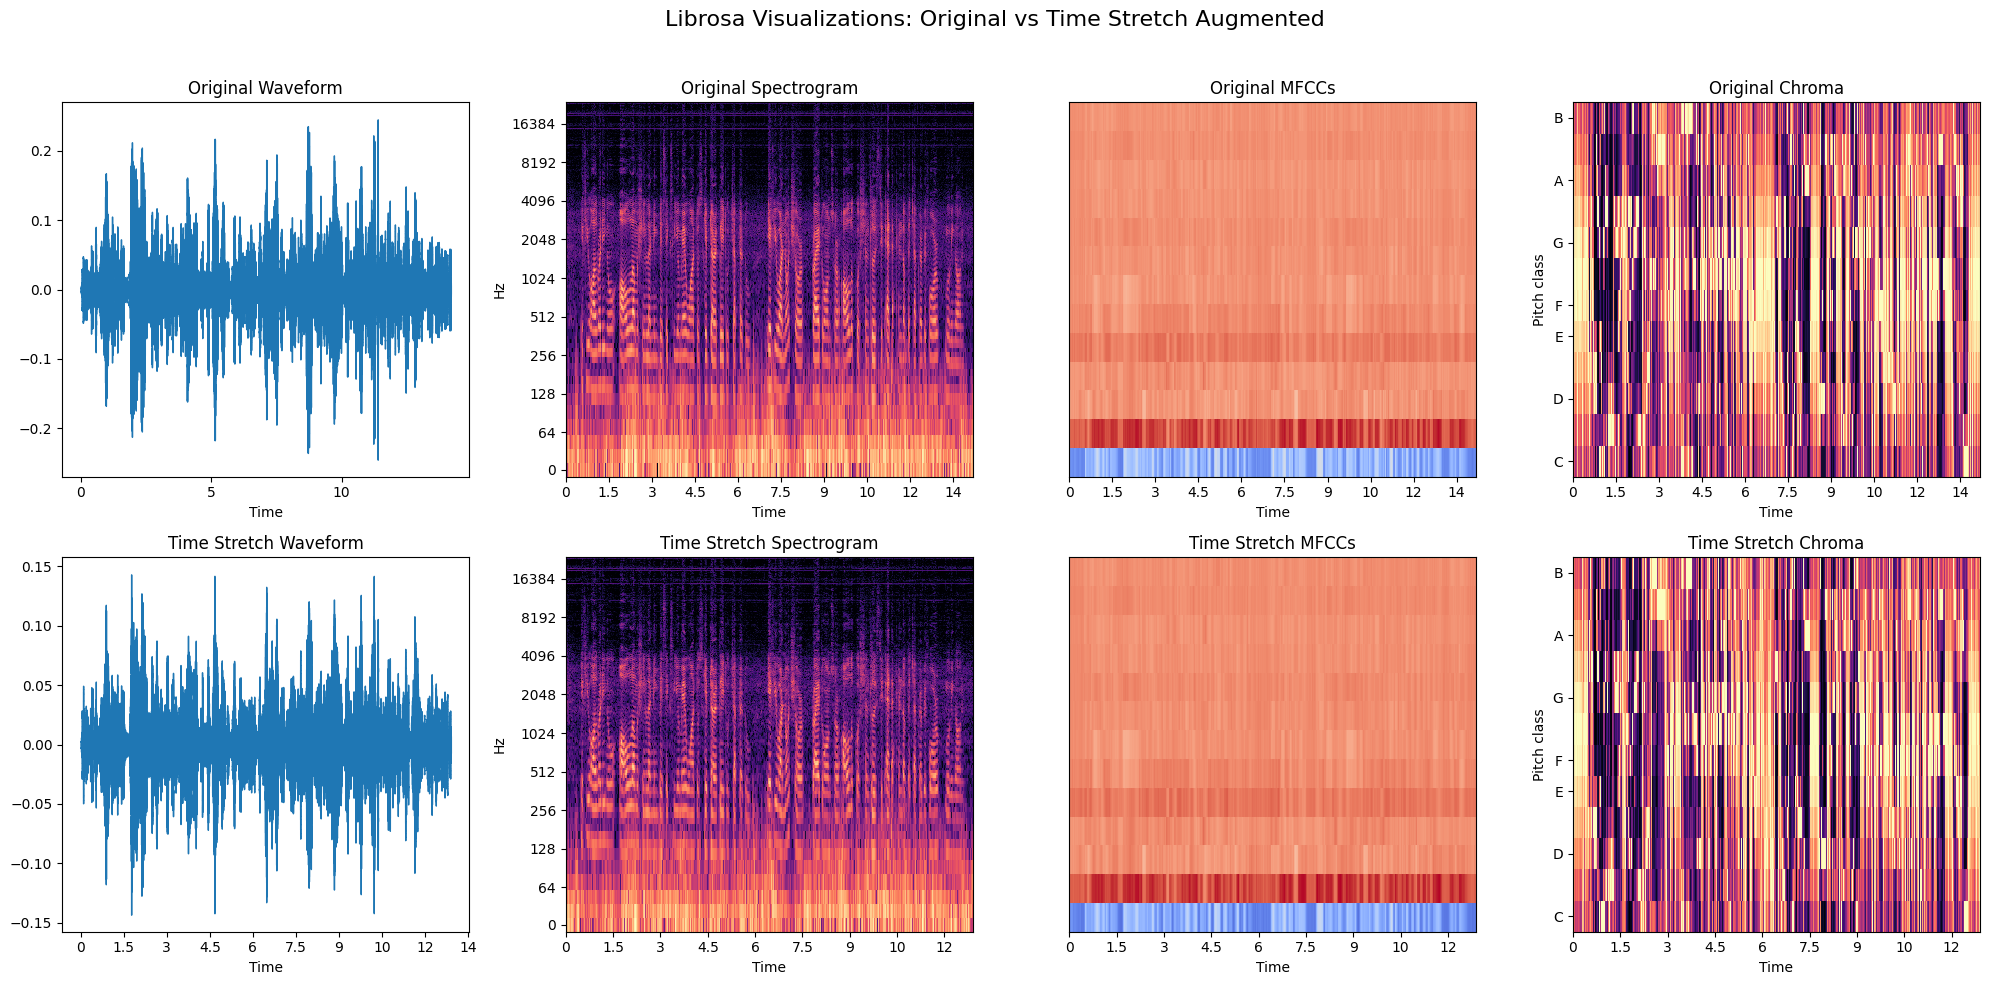

In [ ]:
import os
import numpy as np
import matplotlib.pyplot as plt
import librosa
import librosa.display

# Function to plot waveforms, spectrograms, MFCCs, chroma, etc.
def plot_librosa_visualizations(y_original, sr_original, y_augmented, sr_augmented, augment_type):
    fig, axs = plt.subplots(2, 4, figsize=(20, 10))
    fig.suptitle(f'Librosa Visualizations: Original vs {augment_type} Augmented', fontsize=16)

    # Plot waveform
    librosa.display.waveshow(y_original, sr=sr_original, ax=axs[0, 0])
    axs[0, 0].set_title('Original Waveform')
    librosa.display.waveshow(y_augmented, sr=sr_augmented, ax=axs[1, 0])
    axs[1, 0].set_title(f'{augment_type} Waveform')

    # Plot spectrogram
    D_original = librosa.amplitude_to_db(np.abs(librosa.stft(y_original)), ref=np.max)
    D_augmented = librosa.amplitude_to_db(np.abs(librosa.stft(y_augmented)), ref=np.max)
    librosa.display.specshow(D_original, sr=sr_original, x_axis='time', y_axis='log', ax=axs[0, 1])
    axs[0, 1].set_title('Original Spectrogram')
    librosa.display.specshow(D_augmented, sr=sr_augmented, x_axis='time', y_axis='log', ax=axs[1, 1])
    axs[1, 1].set_title(f'{augment_type} Spectrogram')

    # Plot MFCCs
    mfccs_original = librosa.feature.mfcc(y=y_original, sr=sr_original, n_mfcc=13)
    mfccs_augmented = librosa.feature.mfcc(y=y_augmented, sr=sr_augmented, n_mfcc=13)
    librosa.display.specshow(mfccs_original, sr=sr_original, x_axis='time', ax=axs[0, 2])
    axs[0, 2].set_title('Original MFCCs')
    librosa.display.specshow(mfccs_augmented, sr=sr_augmented, x_axis='time', ax=axs[1, 2])
    axs[1, 2].set_title(f'{augment_type} MFCCs')

    # Plot chroma feature
    chroma_original = librosa.feature.chroma_stft(y=y_original, sr=sr_original)
    chroma_augmented = librosa.feature.chroma_stft(y=y_augmented, sr=sr_augmented)
    librosa.display.specshow(chroma_original, sr=sr_original, x_axis='time', y_axis='chroma', ax=axs[0, 3])
    axs[0, 3].set_title('Original Chroma')
    librosa.display.specshow(chroma_augmented, sr=sr_augmented, x_axis='time', y_axis='chroma', ax=axs[1, 3])
    axs[1, 3].set_title(f'{augment_type} Chroma')

    plt.tight_layout(rect=[0, 0, 1, 0.96])
    plt.show()


# Load a single audio file (example from human class)
file_path = '/content/test/Test(English Real Audio).wav'
y_original, sr_original = librosa.load(file_path, sr=None)

# Data augmentation examples
# 1. Adding slight noise
noise = np.random.normal(0, 0.005, y_original.shape)
y_noise = y_original + noise
plot_librosa_visualizations(y_original, sr_original, y_noise, sr_original, 'Noise')

# 2. Shifting time
shift_range = int(0.1 * len(y_original))
y_shift = np.roll(y_original, shift_range)
plot_librosa_visualizations(y_original, sr_original, y_shift, sr_original, 'Time Shift')

# 3. Pitch shifting
y_pitch_shift = librosa.effects.pitch_shift(y_original, sr=sr_original, n_steps=2)
plot_librosa_visualizations(y_original, sr_original, y_pitch_shift, sr_original, 'Pitch Shift')

# 4. Time stretching
y_stretch = librosa.effects.time_stretch(y_original, rate=1.1)
plot_librosa_visualizations(y_original, sr_original, y_stretch, sr_original, 'Time Stretch')


In [ ]:
from sklearn.metrics.pairwise import cosine_similarity

# Function to compute similarity between features
def compute_similarity(features_human, features_ai):
    return cosine_similarity([features_human], [features_ai])[0][0] * 100  # Convert to percentage

# Function to extract features and compare them individually
def extract_and_compare_per_feature(data_path, human_file, ai_file, fixed_length=40):
    feature_names = ['MFCCs', 'Chroma', 'Mel Spectrogram', 'Spectral Contrast', 'Tonnetz', 'Zero Crossing Rate']

    # Load the human and AI audio files
    y_human, sr_human = librosa.load(os.path.join(data_path, human_file), sr=None)
    y_ai, sr_ai = librosa.load(os.path.join(data_path, ai_file), sr=None)

    # Extract features using your predefined function
    features_human = extract_features_from_audio(y_human, sr_human, fixed_length=fixed_length)
    features_ai = extract_features_from_audio(y_ai, sr_ai, fixed_length=fixed_length)

    # Split features by name and compare them
    split_indices = np.array([fixed_length, fixed_length, fixed_length*2, fixed_length, fixed_length, fixed_length, fixed_length])
    start_idx = 0
    similarities = []

    print("Feature-wise Cosine Similarity:\n")

    # Loop through each feature and compute similarity
    for i, feature_name in enumerate(feature_names):
        feature_len = split_indices[i]
        human_feature_part = features_human[start_idx:start_idx + feature_len]
        ai_feature_part = features_ai[start_idx:start_idx + feature_len]

        similarity = compute_similarity(human_feature_part, ai_feature_part)
        similarities.append(similarity)

        print(f"{feature_name} Similarity: {similarity:.2f}%")
        start_idx += feature_len

    # Compute the overall average similarity
    overall_similarity = np.mean(similarities)
    print(f"\nOverall Similarity: {overall_similarity:.2f}%")

# Example usage:
data_path = '/content/test'
human_file = 'Test(English Real Audio).wav'
ai_file = 'Test(English Clone).wav'

extract_and_compare_per_feature(data_path, human_file, ai_file, fixed_length=40)

Feature-wise Cosine Similarity:

MFCCs Similarity: 98.30%
Chroma Similarity: 99.57%
Mel Spectrogram Similarity: 70.59%
Spectral Contrast Similarity: -13.82%
Tonnetz Similarity: 100.00%
Zero Crossing Rate Similarity: 100.00%

Overall Similarity: 75.77%
